In [2]:
#import sys, os; sys.path.insert(1, os.path.join(sys.path[0], '..'))
import os
os.chdir('..')
import torch
import pandas as pd
from itertools import permutations
import numpy as np
from time import time

from neural_network import NeuralNetwork
from players.uninformed_mcts_player import UninformedMCTSPlayer, RolloutMCTSPlayer
from players.deep_mcts_player import DeepMCTSPlayer
from games.vortex import Vortex_5, Vortex_6, Vortex_7, Vortex_8, Vortex_9
from models.vornet import VorNet

All experiments will use the same model checkpoint for model weights. 

The model was initially trainined for the *Vortex_5_20* game/input shape. 5 is the board side size: a 25 node Vortex board which approximates a 5x5 Hex board in topology. 20 is the number of message passing steps in the construction of the neural network input.

In [2]:
checkpoint = '0'

A match is two games played with the same vortex board topology. On the first game player 0 plays first, on the second player 1 plays first.

Returns: score as list of results:
- player 0 first player 0 wins
- player 0 first player 1 wins
- player 1 first player 0 wins
- player 1 first player 1 wins

In [3]:
def play_match(game, players, verbose=False):

    # permutations to break the dependence on player order in measuring strength.
    matches = list(permutations(np.arange(len(players))))
    
    # Initialize scoreboard
    scores = np.zeros((len(matches), game.get_num_players()))

    # initialise the Vortex board
    vortex_board = game.get_initial_state()

    # Run the matches
    for i, order in enumerate(matches):
        s = vortex_board.copy()

        for p in players:
            p.reset() # Clear player trees to make the next match fair

        game_over = game.check_game_over(s)

        while game_over is None:
            p = order[game.get_player(s)]
            if verbose: print("Player #{}'s turn.".format(p))
            s = players[p].update_state(s)
            game_over = game.check_game_over(s)

        scores[i, list(order)] += game_over

    scores = list(scores.flatten().astype(int))
    return scores

**Evaluate model strength by comparing simulation requirements with an uninformed MCTS agent**

This runs the DeepMCTS model against an uninformed MCTS agent 

- the DeepMCTS agent has a fixed number of simulations 
- the uninformed MCTS agent uses a range of simulation counts

For each combination, *match_n* matches are played.

In [4]:
def simulations_compare(dmcts_sims, umcts_sims, match_n, nn_checkpoint):
    game = Vortex_5_mctspt()
    nn = NeuralNetwork(game, VorNetBN, cuda=True)
    nn.load(nn_checkpoint)
    results = []

    for dmcts_sim in dmcts_sims:
        for umcts_sim in umcts_sims:
            deep_mcts = DeepMCTSPlayer(game, nn, simulations=dmcts_sim)
            rollout_mcts = RolloutMCTSPlayer(game, simulations=umcts_sim)
            players = [deep_mcts, rollout_mcts]

            print("DMCTS: {}, RMCTS: {}".format(dmcts_sim, umcts_sim))

            for i in range(match_n):
                match = [dmcts_sim, umcts_sim, i]
                tic = time()
                scores = play_match(game, players, verbose=False)
                toc = time()
                print("  match {}, score {}, time {:.2f}s".format(i, scores, toc-tic))
                results.append(match + scores)

    players = ['DMCTS', 'RMCTS']
    index = pd.MultiIndex.from_product([players, players], names=['first_player', 'score_player'])
    df = pd.DataFrame(data=results, columns=['dmcts_sim', 'rmcts_sim', 'match', 'p0fp_p0win', 'p0fp_p1win', 'p1fp_p0win', 'p1fp_p1win'])
    df = df.set_index(['dmcts_sim', 'rmcts_sim', 'match'])
    df.columns = index

    return df

In [5]:
dmcts_sims = [500]
# run to 2200?
umcts_sims = range(500, 1501, 100)
# probably needs 500 matches to smooth the results (40 hrs)
match_n = 50

results_df = simulations_compare(dmcts_sims=dmcts_sims, umcts_sims=umcts_sims, match_n=match_n, nn_checkpoint=checkpoint)
results_df.to_csv("./notebooks/results/simulations_compare_2.csv")
results_df.groupby(['dmcts_sim', 'rmcts_sim']).sum()

DMCTS: 500, RMCTS: 500
  match 0, score [1, 0, 0, 1], time 29.47s
  match 1, score [1, 0, 1, 0], time 27.73s
  match 2, score [1, 0, 1, 0], time 26.17s
  match 3, score [1, 0, 0, 1], time 22.93s
  match 4, score [1, 0, 1, 0], time 16.54s
  match 5, score [1, 0, 0, 1], time 21.29s
  match 6, score [1, 0, 1, 0], time 15.42s
  match 7, score [0, 1, 1, 0], time 23.00s
  match 8, score [1, 0, 1, 0], time 22.88s
  match 9, score [1, 0, 0, 1], time 19.78s
  match 10, score [1, 0, 1, 0], time 17.59s
  match 11, score [1, 0, 1, 0], time 27.91s
  match 12, score [1, 0, 1, 0], time 23.14s
  match 13, score [1, 0, 0, 1], time 18.11s
  match 14, score [1, 0, 1, 0], time 34.50s
  match 15, score [1, 0, 0, 1], time 20.19s
  match 16, score [1, 0, 1, 0], time 16.49s
  match 17, score [1, 0, 1, 0], time 18.74s
  match 18, score [1, 0, 1, 0], time 17.47s
  match 19, score [1, 0, 1, 0], time 17.90s
  match 20, score [1, 0, 1, 0], time 17.51s
  match 21, score [1, 0, 0, 1], time 27.32s
  match 22, score [

first_player        DMCTS       RMCTS      
score_player        DMCTS RMCTS DMCTS RMCTS
dmcts_sim rmcts_sim                        
500       500          45     5    35    15
          600          44     6    29    21
          700          38    12    32    18
          800          38    12    22    28
          900          38    12    26    24
          1000         39    11    25    25
          1100         42     8    21    29
          1200         33    17    17    33
          1300         36    14    22    28
          1400         35    15    20    30
          1500         33    17    21    29

In [4]:
dmcts_sims = [40]
umcts_sims = [10, 20, 40, 80, 160, 320, 640, 1280, 2560]
match_n = 20

results_df = simulations_compare(dmcts_sims=dmcts_sims, umcts_sims=umcts_sims, match_n=match_n)
results_df.to_csv("./notebooks/results/simulations_compare_1.csv")
results_df.groupby(['dmcts_sim', 'umcts_sim']).sum()

In [16]:
import pandas as pd

dfs = []
dfs.append(pd.read_csv("../exp_results/experiment2_1642384291.9689753-1642473222.2862575.csv", skiprows=[0,1])) #, index_col=[0,1])
dfs.append(pd.read_csv("../exp_results/experiment5_1643613133.8716695-1643693789.973808.csv", skiprows=[0,1])) #, index_col=[0,1])
# remove oversampling from data
dfs[-1] = dfs[-1][dfs[-1].bmcts_sim > 2500]
df = pd.concat(dfs)
df = df.set_index(['dmcts_sim', 'bmcts_sim', 'match'])
df.columns = ['p0fp_p0win', 'p0fp_p1win', 'p1fp_p0win', 'p1fp_p1win']
df
players = ['DMCTS', 'BMCTS']
index = pd.MultiIndex.from_product([players, players], names=['first_player', 'winner'])
df.columns = index
df.groupby(['dmcts_sim', 'bmcts_sim']).sum()

first_player        DMCTS       BMCTS      
winner              DMCTS BMCTS DMCTS BMCTS
dmcts_sim bmcts_sim                        
100       100         499     1   486    14
          200         493     7   442    58
          300         482    18   397   103
          400         462    38   386   114
          500         453    47   371   129
          1000        400   100   288   212
          1500        384   116   209   291
          2000        375   125   227   273
          2500        366   134   183   317
          3000        371   129   183   317
          3500        346   154   201   299

/home/philh/.local/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<AxesSubplot:xlabel='bmcts_sim'>

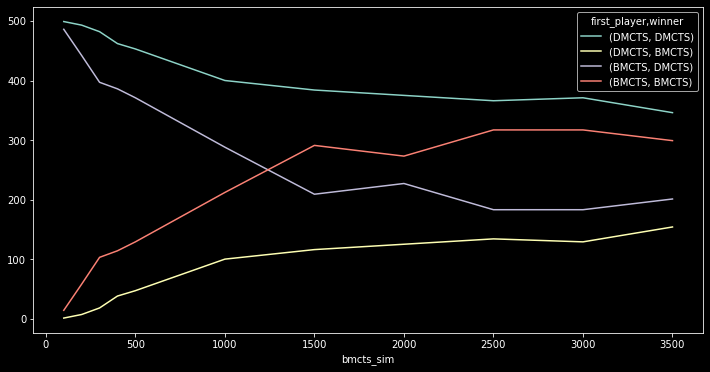

In [17]:
dfp = df.groupby(['dmcts_sim', 'bmcts_sim']).sum()
dfp = dfp.reset_index()
dfp.drop('dmcts_sim', axis=1, inplace=True)
dfp = dfp.set_index(['bmcts_sim'])
#dfp

dfp.plot.line(figsize=(12,6))

<AxesSubplot:xlabel='bmcts_sim'>

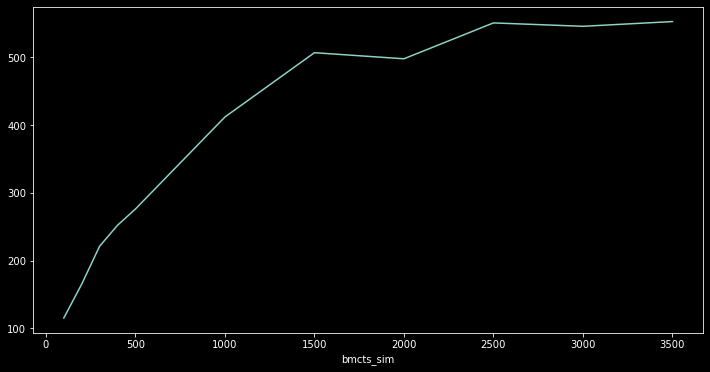

In [46]:
dfp = df.groupby(['dmcts_sim', 'bmcts_sim']).sum()
dfp = dfp.reset_index()
dfp.drop([('DMCTS','DMCTS'), ('BMCTS','DMCTS')], axis=1, inplace=True)

dfp = dfp.set_index(['bmcts_sim'])
dfp = dfp.sum(axis=1)

dfp.plot.line(figsize=(12,6))

**Evaluate performance of DeepMCTS on larger boards than the 25 node board it was trained on**

The DeepMCTS agent is run against the uniformed MCTS agent. For each board size, *match_n* matches are played.

In [7]:
dmcts_sim = 40
umcts_sim = 320
board_sizes = [Vortex_5_20, Vortex_6_20, Vortex_7_20, Vortex_8_20, Vortex_9_20]
match_n = 100
directory = "checkpoints/Vortex_5_20-VorNet"

In [8]:
results = []
for Game in board_sizes:
    board_size = Game.__name__
    game = Game()
    nn = NeuralNetwork(game, VorNet, cuda=True)
    nn.load(checkpoint, directory=directory)

    deep_mcts = DeepMCTSPlayer(game, nn, simulations=dmcts_sim)
    uninformed = UninformedMCTSPlayer(game, simulations=umcts_sim)
    players = [deep_mcts, uninformed]

    print("Board size: {}".format(board_size))

    for i in range(match_n):
        match = [board_size, i]
        scores = play_match(game, players, verbose=False)
        print("  match {}, score {}".format(i, scores))
        results.append(match + scores)

Board size: Vortex_5_20
  match 0, score [1, 0, 0, 1]
  match 1, score [1, 0, 1, 0]
  match 2, score [1, 0, 1, 0]
  match 3, score [1, 0, 1, 0]
  match 4, score [1, 0, 0, 1]
  match 5, score [1, 0, 1, 0]
  match 6, score [1, 0, 0, 1]
  match 7, score [1, 0, 0, 1]
  match 8, score [1, 0, 1, 0]
  match 9, score [1, 0, 1, 0]
  match 10, score [1, 0, 1, 0]
  match 11, score [1, 0, 0, 1]
  match 12, score [1, 0, 1, 0]
  match 13, score [1, 0, 0, 1]
  match 14, score [1, 0, 0, 1]
  match 15, score [1, 0, 1, 0]
  match 16, score [1, 0, 0, 1]
  match 17, score [0, 1, 1, 0]
  match 18, score [1, 0, 1, 0]
  match 19, score [1, 0, 1, 0]
  match 20, score [1, 0, 0, 1]
  match 21, score [1, 0, 1, 0]
  match 22, score [1, 0, 1, 0]
  match 23, score [1, 0, 0, 1]
  match 24, score [1, 0, 0, 1]
  match 25, score [1, 0, 0, 1]
  match 26, score [1, 0, 0, 1]
  match 27, score [1, 0, 1, 0]
  match 28, score [1, 0, 0, 1]
  match 29, score [1, 0, 1, 0]
  match 30, score [1, 0, 0, 1]
  match 31, score [1, 0, 

In [9]:
players = [0,1]
index = pd.MultiIndex.from_product([players, players], names=['first_player', 'score_player'])
df = pd.DataFrame(data=results, columns=['board_size', 'match', 'p0fp_p0win', 'p0fp_p1win', 'p1fp_p0win', 'p1fp_p1win'])
df = df.set_index(['board_size', 'match'])
df.columns = index
df.to_csv("./notebooks/results/board_sizes.csv")
df.groupby(['board_size']).sum()


first_player   0      1    
score_player   0  1   0   1
board_size                 
Vortex_5_20   97  3  55  45
Vortex_6_20   97  3  48  52
Vortex_7_20   97  3  57  43
Vortex_8_20   99  1  74  26
Vortex_9_20   95  5  73  27

Simulating games to generate training data is time consuming on larger boards because untrained agents act close to randomly and this results in more moves required to reach a win state. 

Do models pretrained to smaller boards reduce this initial game simulation time?

In [2]:
# times for 60 games of 36 node Vortex, sides of 6, 100 simulations per action (tree search)
sim_times = [216, 215, 205, 205, 216, 204, 219, 209, 200, 203]
mean_game_time = sum(sim_times) / (len(sim_times) * 30)
print(mean_game_time)

# side 7
sim_times = [339, 366, 448, 518, 499, 490, 471, 457, 467, 452]
mean_game_time = sum(sim_times) / (len(sim_times) * 30)
print(mean_game_time)

# side 8
sim_times = [588, 583, 543, 527, 529, 523, 554, 537, 570, 564]
mean_game_time = sum(sim_times) / (len(sim_times) * 30)
print(mean_game_time)

# side 9
sim_times = [1085, 983, 988, 977, 1016, 933, 974, 1032, 971, 947]
mean_game_time = sum(sim_times) / (len(sim_times) * 30)
print(mean_game_time)

# side 9 - no pretraining
sim_times = [1017, 1088, 1118, 1079, 1076, 1085, 1084, 1029, 1125, 1031]
mean_game_time = sum(sim_times) / (len(sim_times) * 30)
print(mean_game_time)

6.973333333333334
15.023333333333333
18.393333333333334
33.02
35.77333333333333


How does the curriculum trained model compare to the non-pretrained model?

(board size, iterations, training_steps)

curriculum:
- vortex-5-20-gpu.json (5, 100, 1000)
- vortex-6-20-gpu-curriculum.json (6, 10, 1000)
- vortex-7-20-gpu-curriculum.json (7, 10, 1000)
- vortex-8-20-gpu-curriculum.json (8, 10, 1000)
- vortex-9-20-gpu-curriculum.json (9, 10, 10000)

non-pretrained:
- vortex-9-20-gpu-nopt.json (9, 10, 10000)

In [10]:
nopt_checkpoints = range(10, 61, 10)
dmcts_sim=100
match_n=50

In [11]:
game = Vortex_9_20()
nn1 = NeuralNetwork(game, VorNet, cuda=True)
nn1.load(10, directory='checkpoints/Vortex_9_20-VorNet')
nn2 = NeuralNetwork(game, VorNet, cuda=True)
results = []

for nopt_checkpoint in nopt_checkpoints:
    nn2.load(nopt_checkpoint, directory='checkpoints/Vortex_9_20_NoPT-VorNet')

    deep_mcts1 = DeepMCTSPlayer(game, nn1, simulations=dmcts_sim)
    deep_mcts2 = DeepMCTSPlayer(game, nn2, simulations=dmcts_sim)
    players = [deep_mcts1, deep_mcts2]

    for i in range(match_n):
        match = [nopt_checkpoint, i]
        scores = play_match(game, players, verbose=False)
        print("  match {}, score {}".format(i, scores))
        results.append(match + scores)

  match 0, score [0, 1, 1, 0]
  match 1, score [0, 1, 1, 0]
  match 2, score [1, 0, 0, 1]
  match 3, score [1, 0, 1, 0]
  match 4, score [0, 1, 1, 0]
  match 5, score [1, 0, 0, 1]
  match 6, score [1, 0, 1, 0]
  match 7, score [1, 0, 1, 0]
  match 8, score [1, 0, 1, 0]
  match 9, score [1, 0, 1, 0]
  match 10, score [1, 0, 1, 0]
  match 11, score [1, 0, 0, 1]
  match 12, score [1, 0, 1, 0]
  match 13, score [1, 0, 1, 0]
  match 14, score [1, 0, 1, 0]
  match 15, score [1, 0, 0, 1]


In [1]:
df = pd.DataFrame(data=results, columns=['NoPT_checkpoint', 'match', 'p0fp_p0win', 'p0fp_p1win', 'p1fp_p0win', 'p1fp_p1win'])
df = df.set_index(['NoPT_checkpoint', 'match'])
players = ['curriculum', 'non-pretrained']
index = pd.MultiIndex.from_product([players, players], names=['first_player', 'score_player'])
df.columns = index
df.to_csv("./notebooks/results/curriculum.csv")
df.groupby(['NoPT_checkpoint']).sum()

NameError: name 'pd' is not defined

In [38]:
df = pd.read_csv("./notebooks/results/curriculum.csv", skiprows=[1,2])
df.columns=['NoPT_checkpoint', 'match', 'p0fp_p0win', 'p0fp_p1win', 'p1fp_p0win', 'p1fp_p1win']
df = df.set_index(['NoPT_checkpoint', 'match'])
players = ['curriculum', 'non-pretrained']
index = pd.MultiIndex.from_product([players, players], names=['first_player', 'score_player'])
df.columns = index
df.to_csv("./notebooks/results/curriculum.csv")
df.groupby(['NoPT_checkpoint']).sum()

first_player    curriculum                non-pretrained               
score_player    curriculum non-pretrained     curriculum non-pretrained
NoPT_checkpoint                                                        
10                      16              4             16              4
20                      18              2             17              3